## Case 1 - Deterministic
## Case 2 - DRO opt w/o $\gamma$
## Case 3 - DRO opt w $\gamma$
## Case 4 - DRO opt w DRJCC
## Case 5 - DRO opt DRJCC with ESS reserve
## Case 6 - DRO opt DRJCC with ESS reserve but without revenue
## Case 7 - IGDT - DRO opt DRJCC
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys
import time

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 한 단계 위에서 file import 하기 위해서 sys path 설정
sys.path.append(f"{path}/src")
sys.path.append(f"{path}/src/Data_Generation")

from rts_data import generate_wind, generate_gen_dict
from aggregator import aggregator
from gurobiMILP import gurobi_MILP, oos_test
from draw_fig import Single_Case_Plot

In [3]:
### Parameters
DRO_param = {'eps_joint_cvar' : 0.05}
DRO_param['theta'] = 0.5

# Vector for Bonferroni approximation
rho_vectorC = np.linspace(0, 0.0025, 26)

# Number of individual runs (number of coupled datasets in the numerical study)

IR_max = 10


# Number of maximum sample size (N)

N_max = 200

# Number of maximum out of sample data for each individual run (N') for testing
# dataset
OOS_max = 1000

# Number of sample data in training dataset (N)

N = 100;


# Total number of data 

n_total_scen = IR_max * (N_max + OOS_max)

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty with DRO
    #UNIT_TIME: 1 -> 1 hour
    
case_dict = {'case':6, 'UNIT_TIME': 1, 'bid_type':'deterministic', 'n_total_scen': n_total_scen, 'N_max': N_max, 'OOS_max':OOS_max,
             'IR_max': IR_max, 'N': N, 'divide_factor': 1}
case_dict['data_scenario'] = 'random'
case_dict['wt_bound'] = 0.6
case_dict['pv_bound'] = 0.2
case_dict['rand'] = 'uniform'

case_dict['date'] = '20220911'
nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}


model_dict = {'nVPP':1, 'path': path, 'N_PIECE': 10, 'nTimeslot': nTimeslot, 'output_flag': 0}

# Once, set te PV, WT, SMP uncertainties identically in each time (PV: 5%, WT: 10%, SMP: 10%)
uncertainty_dict = {'pv': np.ones(nTimeslot)*0.10 , 'wt': np.ones(nTimeslot)*0.10, 'smp':np.ones(nTimeslot)*0.10}


if case_dict['case']==2:
    
    model_dict['uncertainty'] = uncertainty_dict
    case_dict['bid_type'] = 'risky'
    
elif case_dict['case'] == 1:
    
    uncertainty_dict = {'pv': np.zeros(nTimeslot), 'wt': np.zeros(nTimeslot), 'smp':np.zeros(nTimeslot)}
    model_dict['uncertainty'] = uncertainty_dict
    

In [5]:
# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':4,'PV':2, 'ESS':1, 'DG':2}
    wt_list = [1800, 2000, 1700, 2000]
    pv_list = [1000, 850, 700, 700]
    ess_list = [400]
    capacity_list = [2000]
    dg_list = [800, 700, 900]
    max_list = [wt_list, pv_list, ess_list, capacity_list, dg_list]
    
    dg_dict_list = []
    for j in range(nGen_dict['DG']):
        dg_dict_list.append(generate_gen_dict(j,dg_list[j], model_dict))
    model_dict['dg_dict_list'] = dg_dict_list
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict, case_dict))
    vpp_list[i].set_der_power(max_list)
    vpp_list[i].set_smp_data(case_dict['date'])
    vpp_list[i].set_profile(case_dict['N'],0)
    vpp_list[i].set_res_cov()
    
vpp_list[0].get_res_table()

Error
'aggregator' object has no attribute 'wt_uncert'
Aggregator set_res_table method
Uncertainty does not exist
Data Generated by historical data
Data Generated by historical data
Data Generated by historical data
Data Generated by historical data
Set_Res_Cov
Set_Res_Cov


,name,type,number,min_power,max_power,capacity
0,WT1_cvpp1,WT,1,0.0,1800,NaN
1,WT2_cvpp1,WT,2,0.0,2000,NaN
2,WT3_cvpp1,WT,3,0.0,1700,NaN
3,WT4_cvpp1,WT,4,0.0,2000,NaN
4,PV5_cvpp1,PV,5,0.0,1000,NaN
5,PV6_cvpp1,PV,6,0.0,850,NaN
6,ESS7_cvpp1,ESS,7,-400.0,400,2000.0
7,DG8_cvpp1,DG,8,80.0,800,NaN
8,DG9_cvpp1,DG,9,70.0,700,NaN


In [6]:
# Gurobi Optimization Model

#case_dict['theta'] = DRO_param['theta']* Wmu
#case_dict['theta'] = np.reshape(case_dict['theta'], -1)
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
case_dict['eps'] = DRO_param['eps_joint_cvar']
case_dict['beta'] = 0.1
case_dict['alpha_max'] = 0.2
case_dict['GRID_PIECE'] = 100
case_dict['calc_rad'] = True
#case_dict['theta'] = np.array([0.05]*24)

mip_gap = 0.0001
feas_tol = 1e-4
time_limit = 600
case_dict['case'] = 6


# Gurobi Optimization Model

base_opt = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)

sol1, obj_dict1, P_dict1, U_dict1, slack_dict1 = base_opt.optimize(mip_gap, feas_tol)
base_obj = base_opt.m.objVal


--------------------------------------------
--------------------------------------------

Does not Cosidered alpha
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 7.415974855422974


In [7]:
print(base_obj)

10010732.365953667


In [8]:
lhs_array1, rhs_array1, check_igdt_array1, ratio_igdt1 = oos_test(base_opt, vpp_list[0], 1000,'WDRCC')
print(check_igdt_array1.mean(axis=1))
print(ratio_igdt1)

[ 0.966000  0.960000  0.933000  0.966000  0.965000  0.957000  0.964000
  0.967000  0.976000  0.972000  0.979000  0.966000  0.977000  0.938000
  0.987000  0.955000  0.934000  0.944000  0.970000  0.980000  0.981000
  0.971000  0.965000  0.936000]
0.962875


In [9]:
# base_obj = 4333531.764487116

In [10]:
# Gurobi Optimization Model
case_dict['case'] = 7
# Set the parameter for DRO
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
#case_dict['theta'] = np.array([0.05]*24)
# Set the parameter for DRCC
case_dict['eps'] = DRO_param['eps_joint_cvar']

# Set the parameter for IGDT
case_dict['beta'] = 0.1
case_dict['alpha_max'] = 0.3
case_dict['GRID_PIECE'] = 100

case_dict['calc_rad'] = True
opt_bid_igdt = gurobi_MILP('opt bid_igdt', vpp_list[0], model_dict, case_dict)
opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
mip_gap = 0.0001
feas_tol = 1e-4
sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)


Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Optimal Solution:
Optimization Duration Time: 59.82012987136841


In [11]:
opt_bid_igdt.m.objVal

0.07673877624869944

In [12]:
obj_dict

{'obj_risk_averse': array([ 31867.132232,  31390.488608,  28350.549247,  31690.371546,
         29590.553402,  31643.791763,  44279.380570,  41164.057037,
         49432.384797,  48965.231414,  44492.924764,  32839.020281,
         29315.137157,  32243.565920,  42395.681018,  42212.581622,
         61578.309889,  57598.633153,  63452.759929,  60231.907533,
         62790.560399,  49630.453085,  42680.202371,  26421.005400]),
 'obj1': array([ 425728.607798,  419371.620708,  378772.964436,  423301.783927,
         395304.498473,  422685.646688,  591281.182941,  549743.535833,
         659926.798524,  653690.258700,  593984.561273,  438604.349373,
         391699.282712,  430748.187308,  566110.359505,  563695.695456,
         822353.662201,  769401.254340,  847456.335978,  804511.985127,
         838627.008912,  663158.911399,  570488.901879,  353245.904250]),
 'obj2': array([ 20407.919455,  20365.346784,  18746.166191,  18693.659897,
         18700.755342,  18814.282465,  21777.340376, 

In [13]:
case_fig = Single_Case_Plot(vpp_list, opt_bid_igdt, model_dict, case_dict, path)

setPlotStyle()


In [14]:
# Print lhs,rhs of the igdt_constraints

lhs = 0
for t in range(24):
    lhs += opt_bid_igdt.dayahead_smp[t] * P_dict['bid'][t]
    lhs -= opt_bid_igdt.dayahead_smp[t] * slack_dict['z'][t]
    lhs -= obj_dict['obj2'][t]
    lhs -= obj_dict['obj3'][t]
    lhs -= obj_dict['dg_cost'][0][t]
    lhs -= obj_dict['dg_cost'][1][t]
    
rhs = 0

rhs = (1- opt_bid_igdt.beta) * opt_bid_igdt.base_obj
print(lhs, rhs)

9009659.129358314 9009659.129358301


In [15]:
(1-opt_bid_igdt.beta)*opt_bid_igdt.base_obj

9009659.129358301

In [16]:
obj1 = obj_dict['obj1']
print(obj1)

try:
    obj2 = obj_dict['obj2']
    obj3 = obj_dict['obj3']
    print(obj2)
    print(obj3)
    
except:
    print("no obj2, obj3")

try:
    obj3_full = obj_dict['obj3_full']
except:
    pass
print(sum(obj1))
print(sum(obj2))
print(sum(obj3))

print(sum(sum(obj_dict['dg_cost'])))

print(opt_bid_igdt.m.objVal)

[ 425728.607798  419371.620708  378772.964436  423301.783927
  395304.498473  422685.646688  591281.182941  549743.535833
  659926.798524  653690.258700  593984.561273  438604.349373
  391699.282712  430748.187308  566110.359505  563695.695456
  822353.662201  769401.254340  847456.335978  804511.985127
  838627.008912  663158.911399  570488.901879  353245.904250]
[ 20407.919455  20365.346784  18746.166191  18693.659897  18700.755342
  18814.282465  21777.340376  21777.340376  20422.110345  20229.114236
  18381.460308  18381.460308  20341.222270  20419.272167  20434.882146
  21087.663104  32062.897723  34754.909628  34756.328717  34764.843252
  34756.328717  34756.328717  34756.328717  23647.699728]
[-0.000000 -0.000000  0.000000  0.000000 -0.000000 -0.000000  0.000000
 -0.000000 -0.000000  0.000000  0.000000 -0.000000  0.000000  0.000000
 -0.000000 -0.000000  0.000000 -0.000000 -0.000000  0.000000  0.000000
 -0.000000  0.000000  0.000000]
13573893.297740785
583235.6609719329
-1.150901

In [17]:
lhs_array, rhs_array, check_igdt_array, ratio_igdt = oos_test(opt_bid_igdt, vpp_list[0], 1000,'WDRCC')
print(check_igdt_array.mean(axis=1))
print(ratio_igdt)

[ 0.966000  0.960000  0.933000  0.968000  0.965000  0.957000  0.964000
  0.967000  0.976000  0.970000  0.979000  0.966000  0.973000  0.986000
  0.987000  0.971000  0.934000  0.944000  0.970000  0.980000  0.981000
  0.971000  0.965000  0.936000]
0.965375


In [18]:
for t in range(24):
    print(np.round(P_dict1['bid'][t],2),np.round(P_dict['bid'][t],2))

3433.28 2960.35
3403.26 2922.25
3032.57 2867.32
3164.0 3213.4
3417.5 2999.73
3414.94 3188.16
3775.0 3853.0
3816.32 3582.32
4753.61 4585.69
4994.58 4585.69
5183.92 4585.69
3916.12 3386.12
3315.9 2732.66
3663.59 2993.59
4205.98 3931.32
3970.47 3793.38
3638.39 3639.7
3140.26 3141.57
3646.21 3460.14
3152.86 3283.99
3365.21 3424.09
2706.34 2707.66
2327.98 2329.29
2118.5 2119.81


In [19]:
w_reserve = sum(P_dict['dg_ru']) + sum(P_dict['RU_esschg']) + sum(P_dict['RU_essdis'])
wo_reserve = sum(P_dict1['dg_ru']) + sum(P_dict1['RU_esschg']) + sum(P_dict1['RU_essdis'])
for t in range(24):
    print(np.round(wo_reserve[t],2),np.round(w_reserve[t],2))


437.08 483.19
428.99 475.96
445.98 461.33
514.41 521.58
439.48 480.08
433.56 455.06
439.13 430.15
431.89 454.11
570.48 586.09
482.25 511.03
520.0 578.64
386.75 438.57
60.93 99.61
0.0 199.71
321.04 347.33
245.94 351.71
256.05 254.74
252.46 251.15
379.58 397.01
288.31 274.02
269.47 262.4
205.61 204.3
66.51 65.2
110.37 109.06


In [20]:
scen = 4
all_obj_dicts = []
all_P_dicts = []
all_U_dicts = []
all_objVal = []
all_solve_time = []
all_alpha = []
all_reliable = []
all_reliable_array = []
all_beta = []
all_igdt_obj_list = []
case_dict['case'] = 7
start_time = time.time()
for i in range(scen):
    
    print("*"*30)
    print("iterion i :", i)
    print("iterion i :", i)
    print("iterion i :", i)
    print("*"*30)
    
    case_dict['beta'] = (i+1) * 0.05
    
    
    # Gurobi Optimization Model
    opt_bid_igdt = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
    opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
    sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)
    
    igdt_profit = sum(obj_dict['obj1'] - obj_dict['obj_risk_averse'] - obj_dict['obj2'] - obj_dict['obj3'] - sum(obj_dict['dg_cost']))
    all_igdt_obj_list.append(igdt_profit)
    all_obj_dicts.append(obj_dict) 
    all_P_dicts.append(P_dict)
    all_U_dicts.append(U_dict)
    all_objVal.append(opt_bid_igdt.m.objVal)
    all_solve_time.append(opt_bid_igdt.opt_solve_time)
    all_alpha.append(slack_dict['alpha'])
    all_beta.append(case_dict['beta'])        
end_time = time.time()
total_solution_time = end_time - start_time
print(total_solution_time)

******************************
iterion i : 0
iterion i : 0
iterion i : 0
******************************
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Optimal Solution:
Optimization Duration Time: 41.2519211769104
******************************
iterion i : 1
iterion i : 1
iterion i : 1
******************************
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
itera

In [21]:
df = pd.DataFrame(all_alpha)
df1 = pd.DataFrame(all_solve_time)
df2 = pd.DataFrame(all_igdt_obj_list)

# Specify the Excel file path where you want to export the data
excel_file = f'{path}/result/igdt_output_alpha.xlsx'
excel_file1 = f'{path}/result/igdt_output_solve_time.xlsx'
excel_file2 = f'{path}/result/igdt_output_objVal.xlsx'
# Use the to_excel method to export the DataFrame to an Excel file
df.to_excel(excel_file, index=False)
df.to_excel(excel_file1, index=False)
df.to_excel(excel_file2, index=False)

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


<Figure size 9000x2250 with 0 Axes>

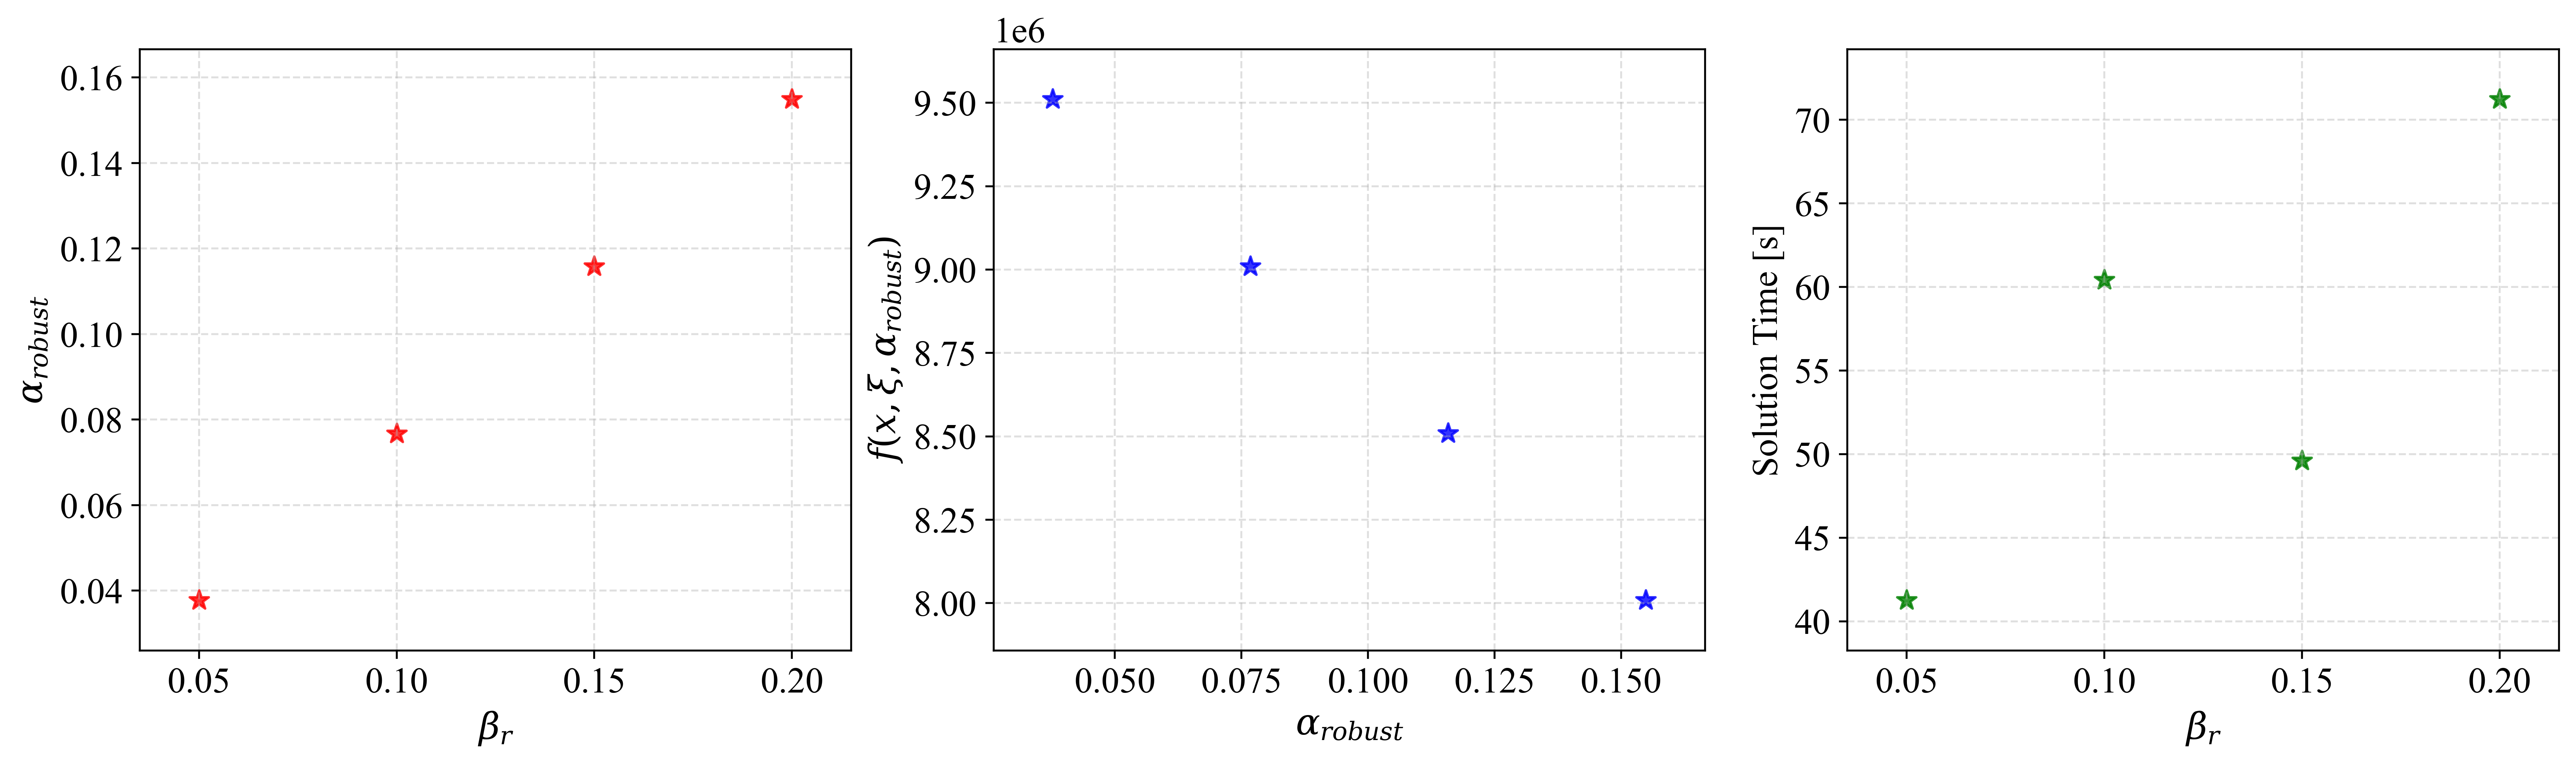

In [22]:
igdt_list = [all_alpha, all_beta, all_igdt_obj_list, all_solve_time]
case_fig.make_igdt_plot(igdt_list, save_flag = True, fig_size=(18,4.5))

In [23]:
for t in range(len(all_alpha)):
    print(all_alpha[t], all_beta[t], all_igdt_obj_list[t], all_solve_time[t])

0.037734267807100604 0.05 9510195.74765602 41.2519211769104
0.07673877624869944 0.1 9009659.129358314 60.4032039642334
0.11583232077600042 0.15000000000000002 8509122.511060607 49.5989716053009
0.15488632983745054 0.2 8008585.892762919 71.21278309822083


In [24]:
scen = 20
all_obj_dicts1 = []
all_P_dicts1 = []
all_U_dicts1 = []
all_objVal1 = []
all_solve_time1 = []
all_alpha1 = []
all_reliable1 = []
all_reliable_array1 = []
all_beta1 = []
all_igdt_obj_list1 = []
grid_piece_list1 = []
all_opt_bid_list1 = []
case_dict['case'] = 7
start_time = time.time()
case_dict['beta'] = 0.1
case_dict['GRID_PIECE'] = 100
all_slack_dict1 = []
for i in range(scen):
    
    print("*"*30)
    print("iterion_grid_piece i :", i)
    print("iterion i :", i)
    print("iterion i :", i)
    print("*"*30)
    
    case_dict['GRID_PIECE'] = (i+1) * 10
    
    
    # Gurobi Optimization Model
    opt_bid_igdt = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
    opt_bid_igdt.set_igdt_params(base_obj, case_dict['beta'])
    sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid_igdt.optimize(mip_gap, feas_tol)
    igdt_profit = sum(obj_dict['obj1'] - obj_dict['obj_risk_averse'] - obj_dict['obj2'] - obj_dict['obj3'] - sum(obj_dict['dg_cost']))
    
    all_opt_bid_list1.append(opt_bid_igdt)
    all_igdt_obj_list1.append(igdt_profit)
    
    grid_piece_list1.append(case_dict['GRID_PIECE'])
    all_obj_dicts1.append(obj_dict) 
    all_P_dicts1.append(P_dict)
    all_U_dicts1.append(U_dict)
    all_objVal1.append(opt_bid_igdt.m.objVal)
    all_solve_time1.append(opt_bid_igdt.opt_solve_time)
    all_alpha1.append(slack_dict['alpha'])
    all_beta1.append(case_dict['beta'])
    all_slack_dict1.append(slack_dict)
end_time = time.time()
total_solution_time = end_time - start_time
print("total_solution_time :", total_solution_time )

******************************
iterion_grid_piece i : 0
iterion i : 0
iterion i : 0
******************************
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Optimal Solution:
Optimization Duration Time: 25.36299705505371
******************************
iterion_grid_piece i : 1
iterion i : 1
iterion i : 1
******************************
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iterati

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
start add_igdt_constraints
add_igdt_risk_averse_constraints sucessfully
End add_igdt_constarints
Optimal Solution:
Optimization Duration Time: 83.1413905620575
******************************
iterion_grid_piece i : 12
iterion i : 12
iterion i : 12
******************************
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.0768519786945359
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
start add_igdt_cons

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


<Figure size 9000x2250 with 0 Axes>

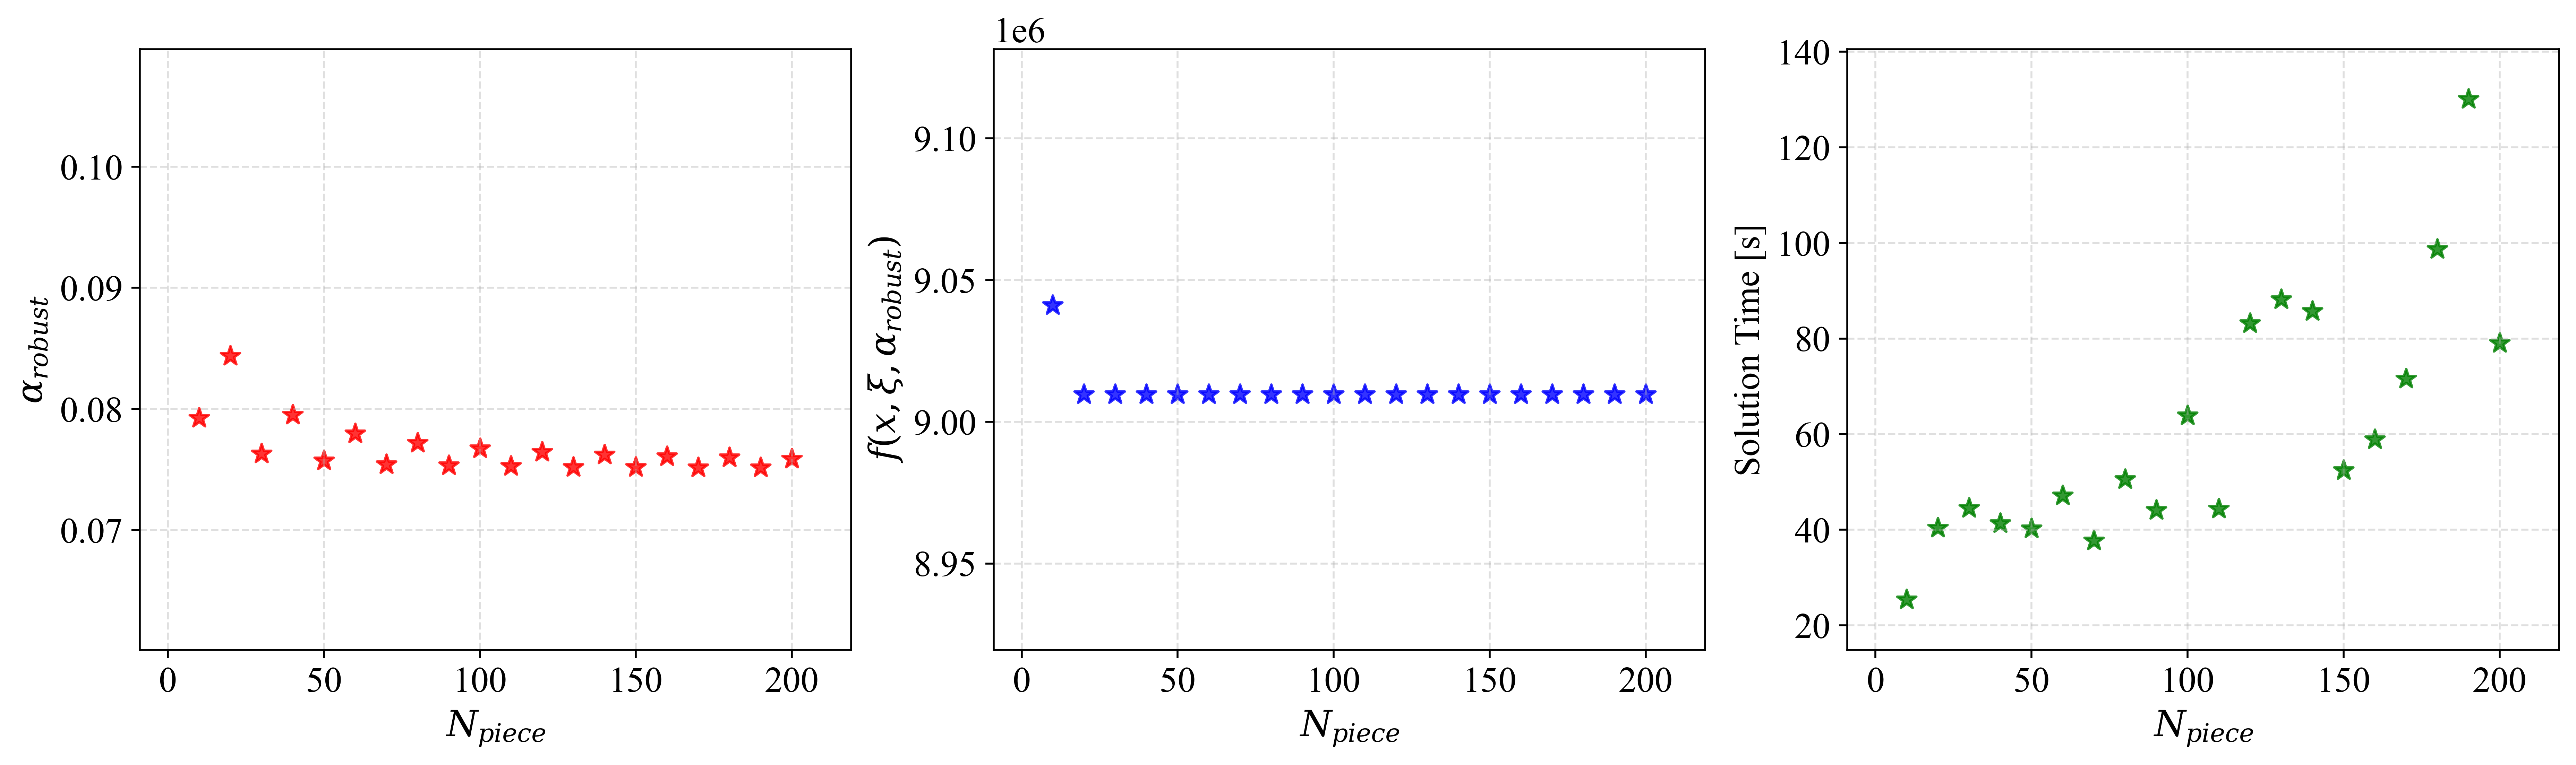

In [25]:
igdt_list = [all_alpha1, grid_piece_list1, all_igdt_obj_list1, all_solve_time1]
case_fig.make_igdt_gridpiece_plot(igdt_list, save_flag = True, fig_size=(18,4.5))

In [26]:
# Print lhs,rhs of the igdt_constraints


for i in range(scen):
    lhs = 0
    for t in range(24):
        lhs += opt_bid_igdt.dayahead_smp[t] * all_P_dicts[i]['bid'][t]
        lhs -= opt_bid_igdt.dayahead_smp[t] * all_slack_dict[i]['z'][t]
        lhs -= all_obj_dicts1[i]['obj2'][t]
        lhs -= all_obj_dicts1[i]['obj3'][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][0][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][1][t]

    rhs = 0

    rhs = (1- opt_bid_igdt.beta) * opt_bid_igdt.base_obj
    print(all_alpha1[i], lhs, rhs)

NameError: name 'all_slack_dict' is not defined

In [ ]:
# Print lhs,rhs of the igdt_constraints


for i in range(scen):
    lhs = 0
    for t in range(24):
        lhs += opt_bid_igdt.dayahead_smp[t] * all_P_dicts[i]['bid'][t]
        lhs -= opt_bid_igdt.dayahead_smp[t] * all_slack_dict[i]['z'][t]
        lhs -= all_obj_dicts1[i]['obj2'][t]
        lhs -= all_obj_dicts1[i]['obj3'][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][0][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][1][t]

    rhs = 0

    rhs = (1- opt_bid_igdt.beta) * opt_bid_igdt.base_obj
    print(all_alpha1[i], all_P_dicts[i]['bid'][t], all_slack_dict[i]['z'][t], all_obj_dicts1[i]['obj2'][t], (all_obj_dicts1[i]['dg_cost'][0][t] + all_obj_dicts1[i]['dg_cost'][1][t]))

In [ ]:
# Print lhs,rhs of the igdt_constraints


for i in range(scen):
    lhs = 0
    for t in range(24):
        lhs += opt_bid_igdt.dayahead_smp[t] * all_P_dicts[i]['bid'][t]
        lhs -= opt_bid_igdt.dayahead_smp[t] * all_slack_dict[i]['z'][t]
        lhs -= all_obj_dicts1[i]['obj2'][t]
        lhs -= all_obj_dicts1[i]['obj3'][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][0][t]
        lhs -= all_obj_dicts1[i]['dg_cost'][1][t]

    rhs = 0

    rhs = (1- opt_bid_igdt.beta) * opt_bid_igdt.base_obj
    print(all_alpha1[i] * all_P_dicts[i]['bid'][t], all_slack_dict[i]['z'][t])

In [ ]:
all_igdt_obj_list1

In [ ]:
plt.figure()
plt.rcParams["figure.figsize"] = (18,6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# Bid Graph
ax1 = plt.subplot(131)
ax1.scatter(all_beta,all_alpha, marker = '*', s=50, color='red', alpha = 0.8)
ax1.set_xlabel(r"$\beta_r$")
ax1.set_ylabel(r"$\alpha_{robust}$")


ax2 = plt.subplot(132)
ax2.scatter(all_alpha,all_beta, marker = '*', s=50, color='red', alpha = 0.8)
ax2.set_xlabel(r"$\alpha_{robust}$")
ax2.set_ylabel(r"$f(x,\xi,\alpha)$")        

ax3 = plt.subplot(133)
ax3.scatter(all_beta,all_solve_time, marker = '*', s=50, color='red', alpha = 0.8)
ax3.set_xlabel(r"$\beta_r$")
ax3.set_ylabel("Solution Time [s]") 

In [ ]:
total_solution_time

In [ ]:
all_slack_dict[3]['alpha_dx']

In [ ]:
all_slack_dict[2]['alpha_dx']

In [ ]:
all_slack_dict[1]['alpha_dx']

In [ ]:
all_alpha1